# Red Neuronal MultiCapa

## Imports

In [435]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style(grid=False)

from get_images_script import get_images

## Load data

- **Data Loading:**  
  The `get_images` function loads the MNIST data from the specified raw path. It returns:
  - `x_train_num` and `y_train_num`: Training images and labels.
  - `x_test_num` and `y_test_num`: Testing images and labels.
  
- **Reshaping and Data Type Conversion:**  
  The images are reshaped to 2D arrays where each image is flattened (28×28 → 784 pixels). The data is also converted to `np.float32` for numerical processing.
  
- **Splitting:**  
  The training set is split into:
  - **Training Set:** First 50,000 examples.
  - **Validation Set:** Remaining 10,000 examples.
  
- **Statistics:**  
  The mean, standard deviation, and minimum pixel value of `x_train` are printed. These values help us understand the original distribution of pixel intensities (typically between 0 and 255).


In [436]:
mnist_raw_path = 'MNIST_db/raw'

x_train_num, y_train_num, x_test_num, y_test_num = get_images(mnist_raw_path)

x_train = x_train_num[:50000].reshape(50000, -1).astype(np.float32)
y_train = y_train_num[:50000].reshape(50000, -1)

x_val = x_train_num[50000:].reshape(10000, -1).astype(np.float32)
y_val = y_train_num[50000:].reshape(10000, -1)

x_test = x_test_num.copy().reshape(10000, -1).astype(np.float32)
y_test = y_test_num.copy().reshape(10000, -1)

print(f"x_train.mean(): {x_train.mean()}")
print(f"x_train.std(): {x_train.std()}")
print(f"x_train.min(): {x_train.min()}")

x_train.mean(): 33.39515686035156
x_train.std(): 78.66619110107422
x_train.min(): 0.0


## Normalization


Normalization is crucial for the following reasons:

- **Improved Numerical Stability:** Neural networks converge faster when input features have a similar scale.
- **Efficient Training:** Centering data around 0 (mean ≈ 0) and scaling it to have a standard deviation of 1 helps in achieving a faster and more stable training process.
- **Avoiding Saturation:** Normalized inputs help prevent neurons from entering saturation regions of activation functions, which can impede learning.

- **Normalization Function:**  
  The function `normalise` takes the mean and standard deviation, and applies the transformation:

    
        x_normalized = (x - x_mean) / x_std
    

- **Parameter Calculation:**  
  The mean (`x_mean`) and standard deviation (`x_std`) are computed from the training set. These parameters are used to normalize all data splits, ensuring consistency.
- **Application:**  
  The normalization is applied to the training, validation, and test sets. After this process, the training data should have a mean close to 0 and a standard deviation close to 1.

In [437]:
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

print(f"Mean: {x_train.mean()}") # Nearly 0
print(f"Std: {x_train.std()}") # Nearly 1

Mean: -3.1638145969736797e-07
Std: 0.9999993443489075


## Show data

In [438]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

The imagen showed is: 9


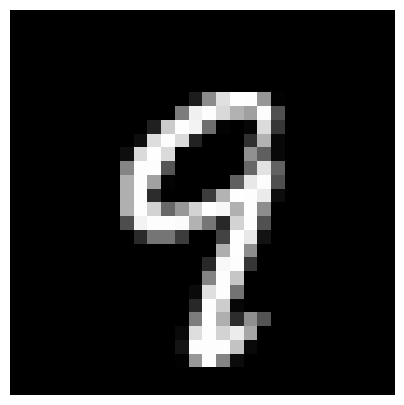

In [439]:
rnd_idx = np.random.randint(len(y_test))
print(f'The imagen showed is: {y_test[rnd_idx, 0]}')
plot_number(x_test_num[rnd_idx])

## Equations for Our Model
1. Linear Transformation: Calculate z^(1).  
2. Non-linear Activation: Apply ReLU to get a^(1).  
3. Output Layer: Calculate z^(2) and apply softmax to get y-hat.  
4. Loss Calculation: Compute -ln(y-hat^(i)) for each sample.  
5. Cost Function: Average the losses to get J(w,b).  
6. Optimization: Adjust w and b to minimize J(w,b).  

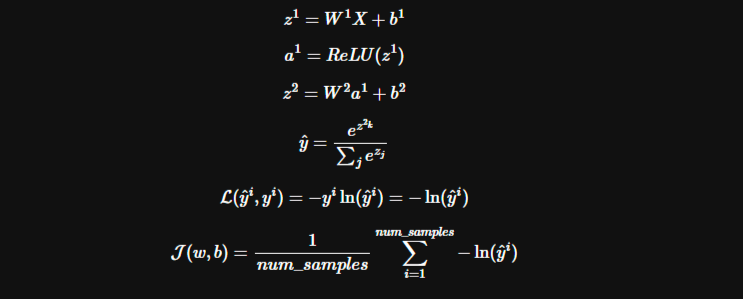

## Aditional Functions

### Mini-batches


In [440]:
def create_minibatches(mb_size, x, y, shuffle=True):
    assert x.shape[0] == y.shape[0], "Error create_minibatches" # Check if the number of examples is the same
    total_data = x.shape[0]
    
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
        
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

## Classes

In [441]:
# Create a subclass of numpy.ndarray to extend its functionality.
class np_tensor(np.ndarray):
    pass 

### Linear Class

In [442]:
class Linear():
    def __init__(self, input_size, output_size):
        '''
        Init parameters with Kaiming He's method
        '''
        # https://numpy.org/doc/2.2/reference/generated/numpy.ndarray.view.html
        # a.view(ndarray_subclass) or a.view(type=ndarray_subclass) just returns an instance of ndarray_subclass 
        # that looks at the same array (same shape, dtype, etc.) This does not cause a reinterpretation of the memory.
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)
        self.b = (np.zeros((output_size, 1))).view(np_tensor)
        
        
    # "dunder" methods: they are called when the object is used as a function
    # forward of the Linear Class
    def __call__(self, X): 
        Z = self.W @ X + self.b
        return Z
    
    # Generic to all the layers
    def backward(self, X, Z):
        X.grad = self.W.T @ Z.grad
        self.W.grad = Z.grad @ X.T
        self.b.grad = np.sum(Z.grad, axis=1, keepdims=True)        

### ReLU Class

In [443]:
class ReLU():
    # Forward pass of the ReLU
    def __call__(self, Z):
        return np.maximum(Z, 0)
    
    # Backward pass of the ReLU
    def backward(self, Z, A):
        Z.grad = A.grad.copy()
        Z.grad[Z <= 0] = 0    

### Sequential Class

In [444]:
class Sequential_layers():
    def __init__(self, layers):
        '''
        layers - list with the objects of the layers, ReLU
        '''
        self.layers = layers
        self.x = None 
        self.outputs = {}
        
    
    def __call__(self, X):
        self.x = X 
        self.outputs['l0'] = self.x
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x)
            self.outputs['l'+str(i)]=self.x
        return self.x     
    
    
    def backward(self):
        for i in reversed(range(len(self.layers))):
            self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])
            
    
    def update(self, learning_rate=1e-3):
        for layer in self.layers:
            if isinstance(layer, ReLU): 
                continue
            
            layer.W = layer.W - learning_rate * layer.W.grad
            layer.b = layer.b - learning_rate * layer.b.grad
            
    
    def predict(self, X):
        return np.argmax(self.__call__(X))            

### Cost Function

In [445]:
def softmaxXEntropy(x,y):
    batch_size = x.shape[1]
    exp_scores = np.exp(x)
    
    probs = exp_scores / exp_scores.sum(axis = 0)
    preds = probs.copy()
    
    # Cost
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size
    
    # Gradient
    probs[y.squeeze(), np.arange(batch_size)] -= 1 # dl/dx
    x.grad = probs.copy()
    
    return preds, cost

## Train Loop

In [446]:
def train(model, epochs, mb_size=128, learning_rate = 1e-3):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            scores = model(x.T.view(np_tensor))
            _, cost = softmaxXEntropy(scores, y)
            model.backward()
            model.update(learning_rate)
        print(f'Cost: {cost}, accuracy: {accuracy(x_val, y_val, mb_size)}')
        
def accuracy(x, y, mb_size):
    correct = 0
    total = 0
    for i, (x,y) in enumerate(create_minibatches(mb_size, x, y)):
        pred = model(x.T.view(np_tensor))
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze())
        total += pred.shape[1]
        
    return correct / total

---

In [447]:
model = Sequential_layers([Linear(784, 200), ReLU(), Linear(200, 10)])
mb_size = 512
learning_rate = 1e-4
epochs = 20

In [448]:
train(model, epochs, mb_size, learning_rate)

Cost: 0.31753537852031793, accuracy: 0.9156
Cost: 0.25470381377278184, accuracy: 0.928
Cost: 0.23642554645344238, accuracy: 0.9355
Cost: 0.19216802031765956, accuracy: 0.9427
Cost: 0.26191190930365815, accuracy: 0.9479
Cost: 0.2218181028835798, accuracy: 0.9525
Cost: 0.19363608677255303, accuracy: 0.955
Cost: 0.18463803916833246, accuracy: 0.958
Cost: 0.12581932406348612, accuracy: 0.9594
Cost: 0.18391323153668934, accuracy: 0.9616
Cost: 0.17595128761053594, accuracy: 0.9617
Cost: 0.14954934399386915, accuracy: 0.9647
Cost: 0.12273305266832776, accuracy: 0.9645
Cost: 0.10486493058151544, accuracy: 0.9655
Cost: 0.10373262956915281, accuracy: 0.9672
Cost: 0.09935053426977286, accuracy: 0.9669
Cost: 0.12533406226801386, accuracy: 0.9685
Cost: 0.09869900568422202, accuracy: 0.9687
Cost: 0.07781539483887315, accuracy: 0.9679
Cost: 0.07836409267331249, accuracy: 0.9697


---

In [495]:
model = Sequential_layers(
    [Linear(784, 512), 
    ReLU(), 
    Linear(512, 256), 
    ReLU(), 
    Linear(256, 128), 
    ReLU(), 
    Linear(128, 64), 
    ReLU(), 
    Linear(64, 10)]
    )

mb_size = 512
learning_rate = 1e-4
epochs = 100

In [496]:
train(model, epochs, mb_size, learning_rate)

Cost: 0.3065991916771997, accuracy: 0.9344
Cost: 0.18522690110359114, accuracy: 0.9492
Cost: 0.2398119669774421, accuracy: 0.9547
Cost: 0.11740953010413654, accuracy: 0.9608
Cost: 0.11821626951256523, accuracy: 0.9626
Cost: 0.1395801899681165, accuracy: 0.9647
Cost: 0.10667343723628131, accuracy: 0.9646
Cost: 0.07231426754259046, accuracy: 0.9676
Cost: 0.030237016455222216, accuracy: 0.9673
Cost: 0.06505249893287235, accuracy: 0.968
Cost: 0.04036481667056067, accuracy: 0.9698
Cost: 0.048971989398788475, accuracy: 0.9694
Cost: 0.0633144312176238, accuracy: 0.9701
Cost: 0.024004985110714645, accuracy: 0.9716
Cost: 0.045767313467546915, accuracy: 0.9715
Cost: 0.01742798019670555, accuracy: 0.9709
Cost: 0.029187157278953817, accuracy: 0.9722
Cost: 0.01688150494204556, accuracy: 0.972
Cost: 0.027141678049312265, accuracy: 0.9736
Cost: 0.021314093254387774, accuracy: 0.9718
Cost: 0.01481644981910378, accuracy: 0.9732
Cost: 0.009803839461027055, accuracy: 0.9728
Cost: 0.01149761740960932, acc

### Test data

In [497]:
print(accuracy(x_test, y_test, mb_size))


0.9774


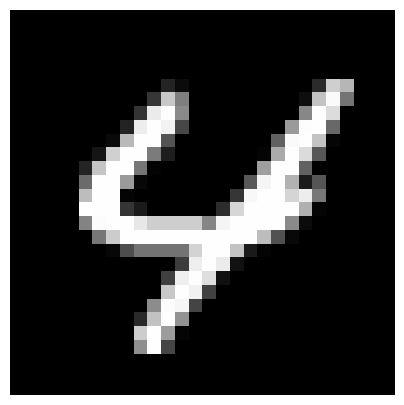

The value predicted for the model:4
The true value: 4


In [505]:
idx = np.random.randint(len(y_test))
plot_number(x_test_num[idx])
pred = model.predict(x_test_num[idx].reshape(-1,1))
print(f'The value predicted for the model:{pred}')
print(f'The true value: {y_test[idx][0]}')